# TicTacToe Game

We first set up a game which can be used for human versus human play. Then, we explain the Monte Carlo Tree Search (MCTS) algorithm and use it for human versus machine and machin vs machine plays.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [35]:
players={1: "x", -1: "o", 0: "."}

def print_state(state):
    print("\n\t", end="")
    print("\n\t".join("  ".join([players[col] for col in row]) for row in state))
    print()     

## TicTacToe Game Setup
In this setup, we play on both sides, i.e., we decide what to play as players take turn. The algorithm calculates when a player wins or there's no move to make (draw) and terminates the game.

In [20]:
class TicTacToe(object):
    def __init__(self, board_size=3, first_player=1):
        self.board_size = board_size
        self.first_player = first_player

    def init_state(self):
        return np.zeros((self.board_size, self.board_size), dtype=np.int8)

    def next_state(self, state, action, player):
        row, col = self.coord(action)
        state[row, col] = player
        return state

    def coord(self, action):
        return action//self.board_size, action%self.board_size
    
    def opponent(self, player):
        return -player

    def won(self, state, action):
        row, col = self.coord(action)
        player = state[row, col]

        row_full = np.sum(state[row, :]) == player * self.board_size
        col_full = np.sum(state[:, col]) == player * self.board_size
        diag_full = np.sum(np.diag(state)) == player * self.board_size
        offdiag_full = np.sum(np.diag(np.fliplr(state))) == player * self.board_size
    
        return row_full or col_full or diag_full or offdiag_full
        
    def available_actions(self, state):
        return np.where(state.reshape(-1) == 0)[0]

    def is_over(self, state, action):
        return self.won(state, action) or (np.sum(state == 0) == 0)

    def result(self, won):
        return 1 if won else 0


### Human-Human Play

In [37]:
t3 = TicTacToe(first_player=1)
state = t3.init_state()
player = t3.first_player

while True:
    print(f"player '{players[player]}' to play...")
    print_state(state)

    available_actions = t3.available_actions(state)
    print(f"available_actions: {available_actions}")
    
    if len(available_actions) == 0:
        print("draw!")
        break        

    action = input(f"provide a valid move: ")
    action = int(action)
    state = t3.next_state(state, action, player)

    if t3.won(state, action):
        print(state)
        print(f"player {players[player]} won!")
        break
    
    player = t3.opponent(player)


player 'x' to play...

	.  .  .
	.  .  .
	.  .  .

available_actions: [0 1 2 3 4 5 6 7 8]
player 'o' to play...

	.  .  .
	.  x  .
	.  .  .

available_actions: [0 1 2 3 5 6 7 8]
player 'x' to play...

	o  .  .
	.  x  .
	.  .  .

available_actions: [1 2 3 5 6 7 8]
player 'o' to play...

	o  .  .
	.  x  .
	.  x  .

available_actions: [1 2 3 5 6 8]
player 'x' to play...

	o  o  .
	.  x  .
	.  x  .

available_actions: [2 3 5 6 8]
player 'o' to play...

	o  o  x
	.  x  .
	.  x  .

available_actions: [3 5 6 8]
player 'x' to play...

	o  o  x
	.  x  .
	o  x  .

available_actions: [3 5 8]
player 'o' to play...

	o  o  x
	x  x  .
	o  x  .

available_actions: [5 8]
player 'x' to play...

	o  o  x
	x  x  o
	o  x  .

available_actions: [8]
player 'o' to play...

	o  o  x
	x  x  o
	o  x  x

available_actions: []
draw!


## Monte Carlo Tree Search

In this setion, we design a machine that can play against human or against another machine. We use Monte Carlo Tree Search (MCTS) to decide on the next move.

For a machine to be able to play against itself, we design it in a way that is agnostic of the player. We can assume that the player is always player 1, and change the perspective so that the machine act as player 2. For calrification, consider the following state in a $3\times 3$ TicTacToe game:

$$
S = 
\begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & -1 \\
0 & 0 & 0
\end{pmatrix}
$$

Player -1 is to play. We can see this is equvalent to player 1 in state $-S$, where all elements are multiplied by $-1$. Thus, we can design MCTS algorithm which is player agnostic.

The MCTS algorithms is composed of four stages as follows:

1. Selection
2. Expansion
3. Simulation
4. Backpropagation

The input to the MCTS algorithm is the current state and the output is a probability distribution of all the possible moves. Based on the distribution, we can decide which action to take. This can be just the move with the highest probability.

<center>
<img src="./images/mcts.png" width="400">
</center>

From the output of the MCTS algorithm, we choose the next action as $(0, 1)$, which prevents the opponent from winning, as detected by the algorithm.

The tree serarch is created as follows. We first create a root node with a given state. Then, we follow the four steps as:

1. Check if the current node is fully expanded or not. A node is fully expanded if it has children and no action can be taken.
2. If the node is fully expanded, we compute the Upper Confidence Bound (UCB) for each of its children and select the one with the highest UCB.
3. Continue the process until you reach a node which is not fully expanded.
4. Expand the node and move to the expanded node.
5. Run a simulation from the current node to determine if the player is won. Return the value.
6. Run backpropagation to update the value_sum and visit_count on all the nodes in the path from the node to the root.

This process is repeated for a set number of iteration. After that we look at the immediate children of the root node and compute the probability distribution of the visit_counts. We use this distribution to determine the next move.

<center>
<img src="./images/mcts-algorithm.png" width="500">
</center>

We use the following formula to compute the UCB of children nodes from a parent node to find out which child to select in the selection step.

$$
\frac{v_c}{n_c}+c\sqrt{\frac{\ln n_p}{n_c}},
$$

where 

* $n_p$ is the visit count of the parent node $P$,
* $n_c$ is the visit count of the child node $C$,
* $v_c$ is the total reward (number of wins minus number of losses),
* $c$ is the exploration factor.

<center>
<img src="./images/mcts-nodes.png" width="200">
</center>


In [41]:
params = {
    "exploratin_factor": np.sqrt(2),
    "num_iters": 1000,
}

In [38]:
class TicTacToe(object):
    def __init__(self, board_size=3, first_player=1):
        self.board_size = board_size
        self.first_player = first_player

    def init_state(self):
        return np.zeros((self.board_size, self.board_size), dtype=np.int8)

    def next_state(self, state, action, player):
        row, col = self.coord(action)
        state[row, col] = player
        return state

    def coord(self, action):
        return action//self.board_size, action%self.board_size
    
    def opponent(self, player):
        return -player

    def opponent_value(self, value):
        return -value
    
    def change_perspective(self, state):
        return -state 
    
    def won(self, state, action):
        if action is None:
            return False
        row, col = self.coord(action)
        player = state[row, col]

        row_full = np.sum(state[row, :]) == player * self.board_size
        col_full = np.sum(state[:, col]) == player * self.board_size
        diag_full = np.sum(np.diag(state)) == player * self.board_size
        offdiag_full = np.sum(np.diag(np.fliplr(state))) == player * self.board_size
    
        return row_full or col_full or diag_full or offdiag_full
        
    def available_actions(self, state):
        return np.where(state.reshape(-1) == 0)[0]

    def is_over(self, state, action):
        return self.won(state, action) or (np.sum(state == 0) == 0)

    def result(self, won):
        return 1 if won else 0


class Node(object):
    def __init__(self, game, state, params, parent=None, parent_action=None):
        '''
        `parent` took `parent_action` which resulted in the current `state`.
        '''
        self.game = game
        self.state = state
        self.params = params
        self.parent = parent
        self.parent_action = parent_action

        self.children = []
        self.available_actions = (state.reshape(-1) == 0).astype(np.int8)

        # reward value for the current state which can be positive or negative.
        self.value_sum = 0
        # number of visits at this node.
        self.visit_count = 0

    def is_fully_expanded(self):
        '''
        Used in the node selection. Starting from the root, we select a child node
        which is fully expanded. We continue this process until we reach a node that
        is not fully expanded. Then, we expand the node.
        '''
        return (np.sum(self.available_actions) == 0) and len(self.children) > 0

    def expected_reward(self):
        return self.value_sum / self.visit_count

    def ucb(self, child):
        '''
        Computes the Upper Confidence Bound (UCB).
        '''
        exploration = np.sqrt(np.log(self.visit_count)/child.visit_count)
        return child.expected_reward() + self.params["exploratin_factor"]*exploration

    def select(self):
        k = np.argmax([self.ucb(child) for child in self.children])
        return self.children[k]

    def expand(self):
        action = np.random.choice(np.where(self.available_actions == 1)[0])
        # mark as explored so it won't be available anymore.
        self.available_actions[action] = 0
        
        # we can assume this player is the player 1, without loss of generality.
        child_state = self.game.next_state(self.state.copy(), action, player=self.game.first_player)
        child_state = self.game.change_perspective(child_state)
        child_node = Node(self.game, child_state, self.params, self, action)

        self.children.append(child_node)
        return child_node

    def simulate(self):
        state = self.state.copy()
        parent_action = self.parent_action
        # We can assume the player at this node is the player 1, without loss
        # of generality. If this player wins we return 1, if opponent wins we return
        # -1, and if draw, we return 0.
        player = self.game.first_player

        while not self.game.is_over(state, parent_action):
            parent_action = np.random.choice(np.where(state.reshape(-1) == 0)[0])
            state = self.game.next_state(state, parent_action, player)
            player = self.game.opponent(player)
        
        result = self.game.result(self.game.won(state, parent_action))
        return result if player == self.game.first_player else self.game.opponent_value(result)                

    def backward(self, reward):
        '''
        Backpropagate reward and visit counts from the node to the root.
        '''
        self.value_sum += reward
        self.visit_count += 1
        # parent node is the opponent of the child node.
        reward = self.game.opponent_value(reward)
        if self.parent is not None:
            self.parent.backward(reward)


class MCTS(object):
    '''
    Monte Carlo Tree Search implementation. It has no notion of players. It sees the state
    from the perspective of alternating players in each iteration. This is useful when two
    machines play as we can just change the perspective.
    '''
    def __init__(self, game, params):
        self.game = game
        self.params = params
        
    def best_action(self, state, parent_action):
        num_iters = self.params["num_iters"]
        root = Node(self.game, state, self.params, parent_action=parent_action)
        
        for _ in range(num_iters):
            # starting from the root, select a child with highest UCB if it's fully expanded, 
            # or expand it.
            node = self.find_node(root)
            reward = node.simulate()
            node.backward(reward)
            
        return self.action_distibution(root)

    def find_node(self, root):
        '''
        Starting from the root node, selects a node that is fully expanded and has highest UCB
        until:
            * The game is over. It return the last node. 
            * It finds a node that is not fully expanded. It expands the node and returns it.
        '''
        node = root
        while not self.game.is_over(node.state, node.parent_action):
            if not node.is_fully_expanded():
                return node.expand()
            node = node.select()
        return node

    def action_distibution(self, root):
        '''
        Returns the probability distribution of the visit counts.
        '''
        out = np.zeros(self.game.board_size**2)
        for child in root.children:
            out[child.parent_action] = child.visit_count
        out /= np.sum(out)
        return out        
        

### Human-Machine Play

player 'x' to play...

	.  .  .
	.  .  .
	.  .  .

valid moves: [0 1 2 3 4 5 6 7 8]
player 'o' to play...

	.  .  .
	.  x  .
	.  .  .

valid moves: [0 1 2 3 5 6 7 8]


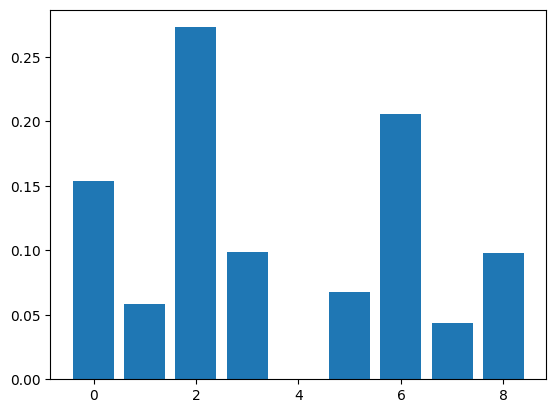

player 'x' to play...

	.  .  o
	.  x  .
	.  .  .

valid moves: [0 1 3 5 6 7 8]
player 'o' to play...

	.  x  o
	.  x  .
	.  .  .

valid moves: [0 3 5 6 7 8]


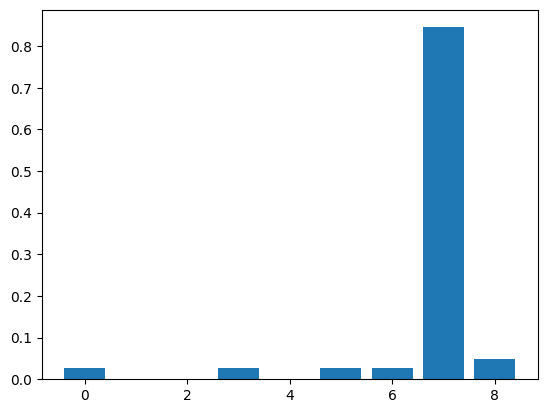

player 'x' to play...

	.  x  o
	.  x  .
	.  o  .

valid moves: [0 3 5 6 8]
player 'o' to play...

	.  x  o
	.  x  .
	.  o  x

valid moves: [0 3 5 6]


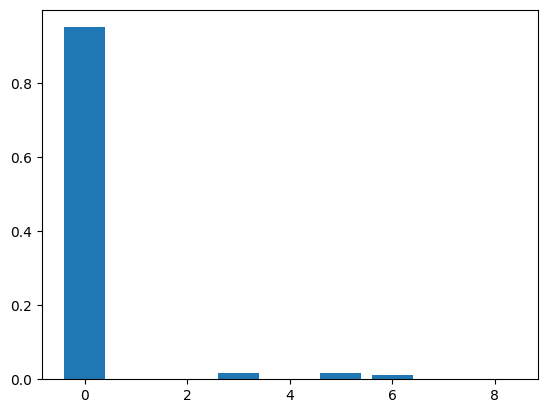

player 'x' to play...

	o  x  o
	.  x  .
	.  o  x

valid moves: [3 5 6]
player 'o' to play...

	o  x  o
	.  x  x
	.  o  x

valid moves: [3 6]


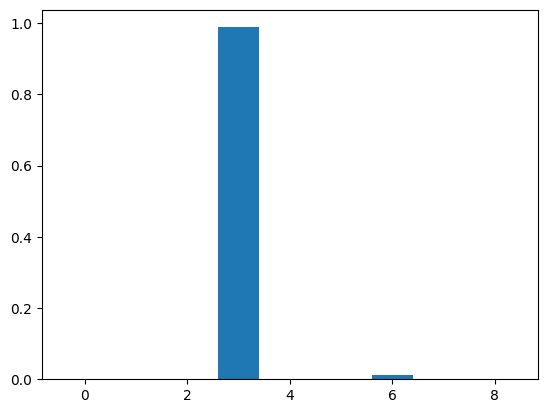

player 'x' to play...

	o  x  o
	o  x  x
	.  o  x

valid moves: [6]
player 'o' to play...

	o  x  o
	o  x  x
	x  o  x

valid moves: []
draw!


In [47]:
t3 = TicTacToe(first_player=1)
state = t3.init_state()
player = t3.first_player

mcts = MCTS(t3, params)

while True:
    print(f"player '{players[player]}' to play...")
    print_state(state)

    available_actions = t3.available_actions(state)
    print(f"valid moves: {available_actions}")
    
    if len(available_actions) == 0:
        print("draw!")
        break        

    if player == t3.first_player:
        action = input(f"provide a valid move: ")
        action = int(action)
    else:
        # mcts sees the state from the perspective of player 1.
        # since it's player -1 now, we change the perspective.
        opponent_state = t3.change_perspective(state)
        action_dist = mcts.best_action(opponent_state, action)
        plt.bar(range(len(action_dist)), action_dist)
        plt.show()
        action = np.argmax(action_dist)

    state = t3.next_state(state, action, player)

    if t3.won(state, action):
        print(state)
        print(f"player {players[player]} won!")
        break
    
    player = t3.opponent(player)


### Machine-Machine Play

player 'x' to play...

	.  .  .
	.  .  .
	.  .  .

available actions: [0 1 2 3 4 5 6 7 8]


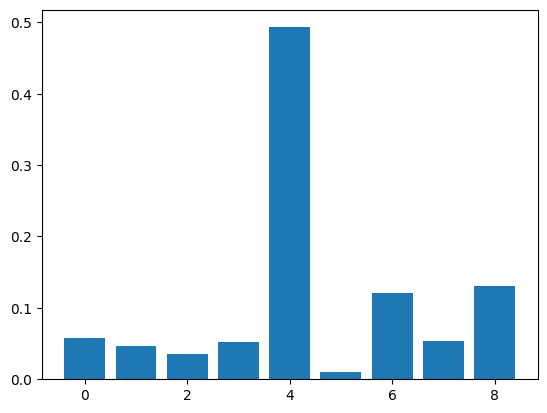

player 'o' to play...

	.  .  .
	.  x  .
	.  .  .

available actions: [0 1 2 3 5 6 7 8]


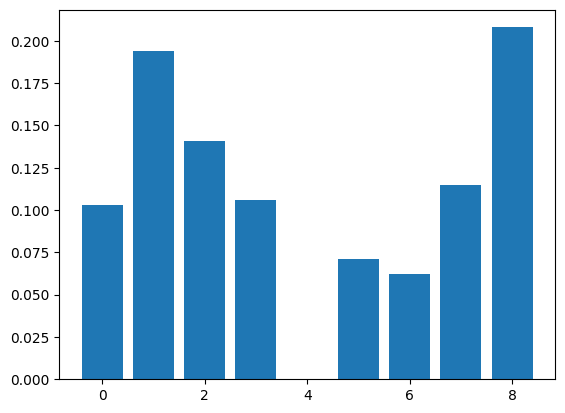

player 'x' to play...

	.  .  .
	.  x  .
	.  .  o

available actions: [0 1 2 3 5 6 7]


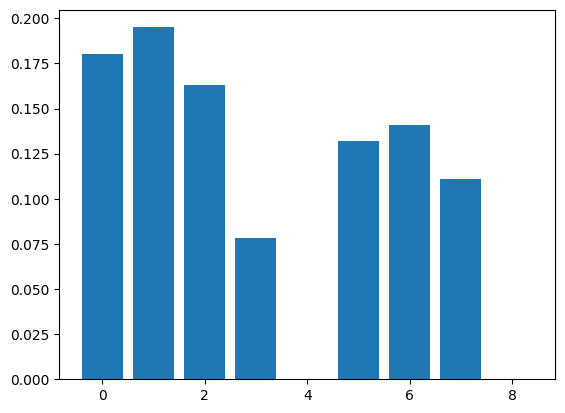

player 'o' to play...

	.  x  .
	.  x  .
	.  .  o

available actions: [0 2 3 5 6 7]


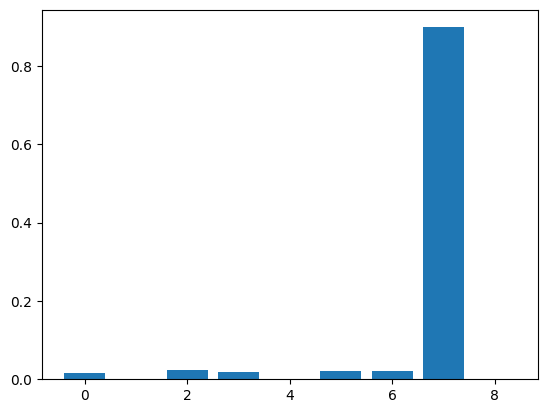

player 'x' to play...

	.  x  .
	.  x  .
	.  o  o

available actions: [0 2 3 5 6]


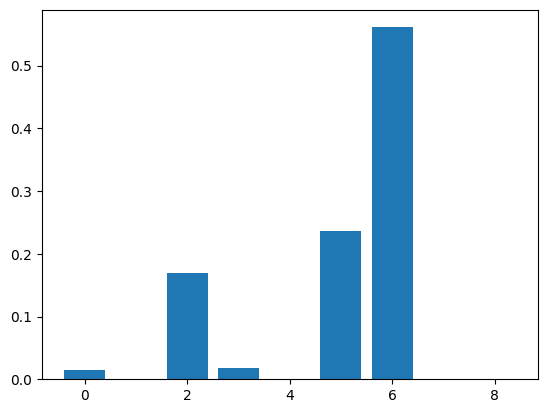

player 'o' to play...

	.  x  .
	.  x  .
	x  o  o

available actions: [0 2 3 5]


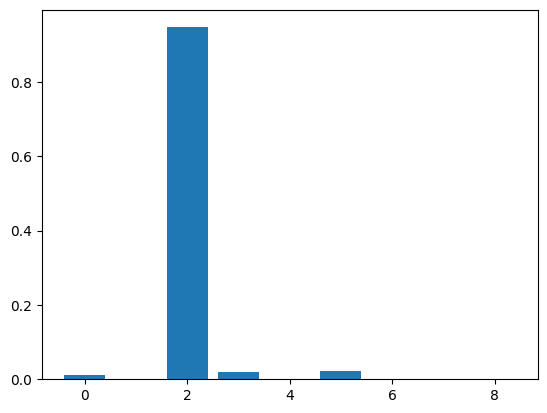

player 'x' to play...

	.  x  o
	.  x  .
	x  o  o

available actions: [0 3 5]


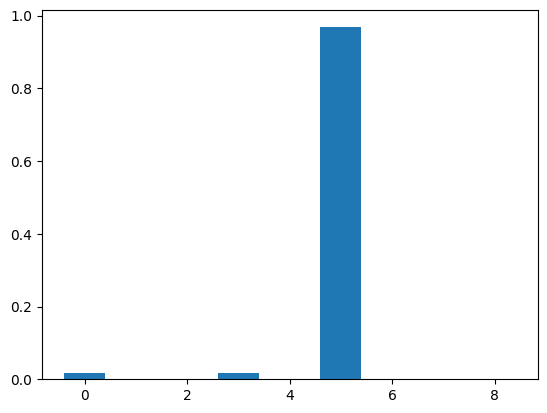

player 'o' to play...

	.  x  o
	.  x  x
	x  o  o

available actions: [0 3]


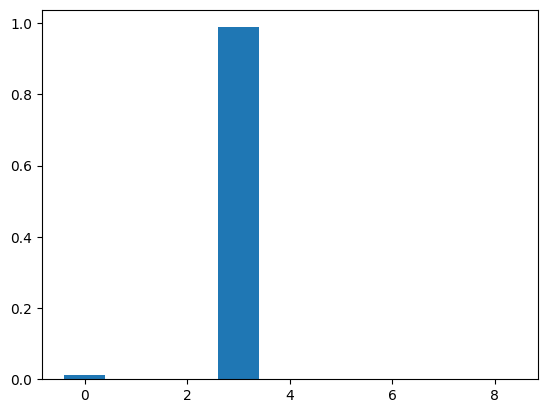

player 'x' to play...

	.  x  o
	o  x  x
	x  o  o

available actions: [0]


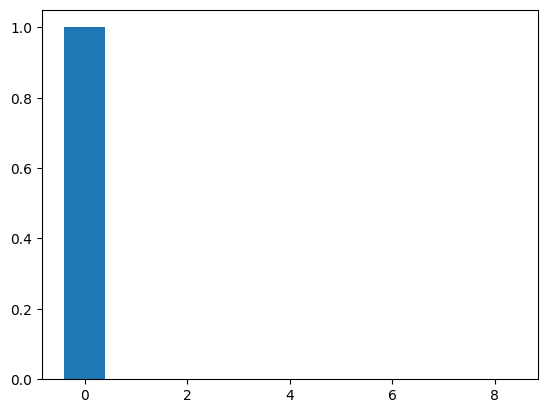

player 'o' to play...

	x  x  o
	o  x  x
	x  o  o

available actions: []
draw!


In [48]:
t3 = TicTacToe(first_player=1)
state = t3.init_state()
player = t3.first_player
action = None

mcts = MCTS(t3, params)

while True:
    print(f"player '{players[player]}' to play...")
    print_state(state)

    available_actions = t3.available_actions(state)
    print(f"available actions: {available_actions}")
    
    if len(available_actions) == 0:
        print("draw!")
        break        
    
    opponent_state = t3.change_perspective(state)
    action_dist = mcts.best_action(opponent_state, action)
    plt.bar(range(len(action_dist)), action_dist)
    plt.show()
    action = np.argmax(action_dist)

    state = t3.next_state(state, action, player)

    if t3.won(state, action):
        print(state)
        print(f"player {players[player]} won!")
        break
    
    player = t3.opponent(player)
